# Steam web api data mining
## Sodelujoči
- Tomaž Štrus
- Anže Košir
- Jan Harej

## Imports

In [1]:
from scripts.imports import *
from scripts.data_variables import *
from scripts.gameStats_functions import *
from scripts.get_read_write import *
import math
import jellyfish

---
# Geting data

Uporabili bomo API, ki ga ponuja Steam: https://developer.valvesoftware.com/wiki/Steam_Web_API#JSON , ven smo dobili naslednje:
* 100k Users (name, username, country, game library, playtime, bans)
* 61k Games (name, achievements, achievements completion)

Funkcije za branje se nahajajo v skriptah, glavna je skripta get_read_write.py, iz kjer se dela asinhrone klice APIja, katera nato doda nove podatke v JSONe, ki jih preberemo spodaj

In [2]:
data = read_all_from_file()
player_ids = data[0] 
player_summaries = data[1]
player_friends = data[2]
player_games = data[3]
player_achievements = data[4]
player_bans = data[5]
global_game_stats = data[6]
game_names= data[7]
print("Current database size: {} users".format(len(player_ids)))
print("Current database size: {} games".format(len(game_names)))


INFO: reading ids
INFO: reading ids finished
INFO: reading summaries
INFO: reading summaries finished
INFO: reading friends
INFO: reading friends finished
INFO: reading games
INFO: reading games finished
INFO: reading achievements
INFO: reading achievements finished
INFO: reading bans
INFO: reading bans finished
INFO: reading global game stats
INFO: reading global game stats finished
INFO: reading game names
INFO: reading game names finished
Current database size: 100000 users
Current database size: 61693 games


# Lokalnost podatkov
Tu pokažemo, da so naši uporabniki porazdeljeni po celem svetu

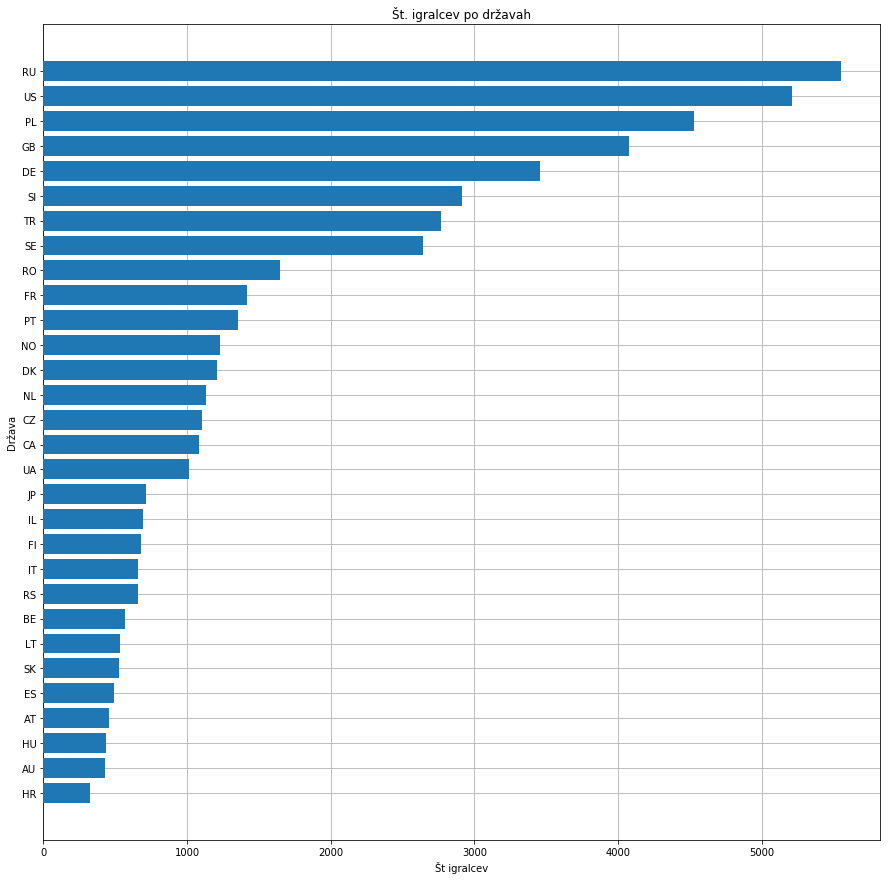

In [3]:
player_countries=dict()
for pid in player_summaries:
    if('cntry' in player_summaries[pid]):
        if(player_summaries[pid]['cntry'] not in player_countries):
            player_countries[player_summaries[pid]['cntry']]=0
        player_countries[player_summaries[pid]['cntry']]+=1
sortedPlayerCountries= sorted(player_countries.items(), key=lambda x: x[1], reverse=True)

def plotCountries( player_countries):
    number=[]
    countries=[]
    for country,persons in player_countries:
        countries.append(country)
        number.append(persons)
    y_pos = np.arange(len(countries))
    plt.figure(figsize=(15,15))
    plt.grid(zorder=0)
    plt.barh(countries,number, align='center', zorder=5)
    #plt.yticks(y_pos, games)
    plt.xlabel("Št igralcev")
    plt.title('Št. igralcev po državah')
    plt.ylabel("Država")
    plt.savefig("assets/country.png",dpi=200,bbox_inches="tight")
    plt.show()
    return None
plotCountries(sortedPlayerCountries[30:0:-1])

## Kupljene igre uporabnikov  (samo za naše prijatelje)
V naslednjih grafim bomo naredili analizo knjižnjice iger, žal smo lahko dobili podatke za samo 600 uporabnikov, ki so bili naši prijatelji, tako da se podatki zelo prilagajajo tudi igram, ki jih imamo mi sami.

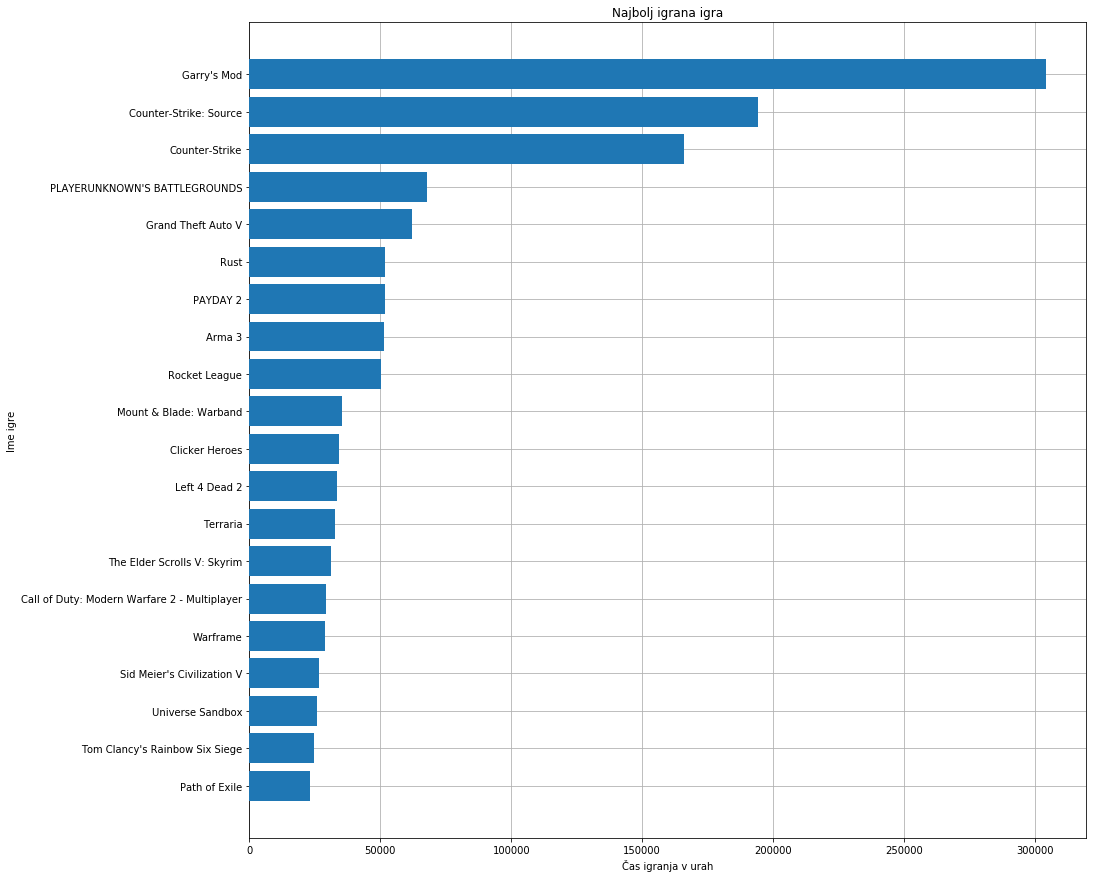

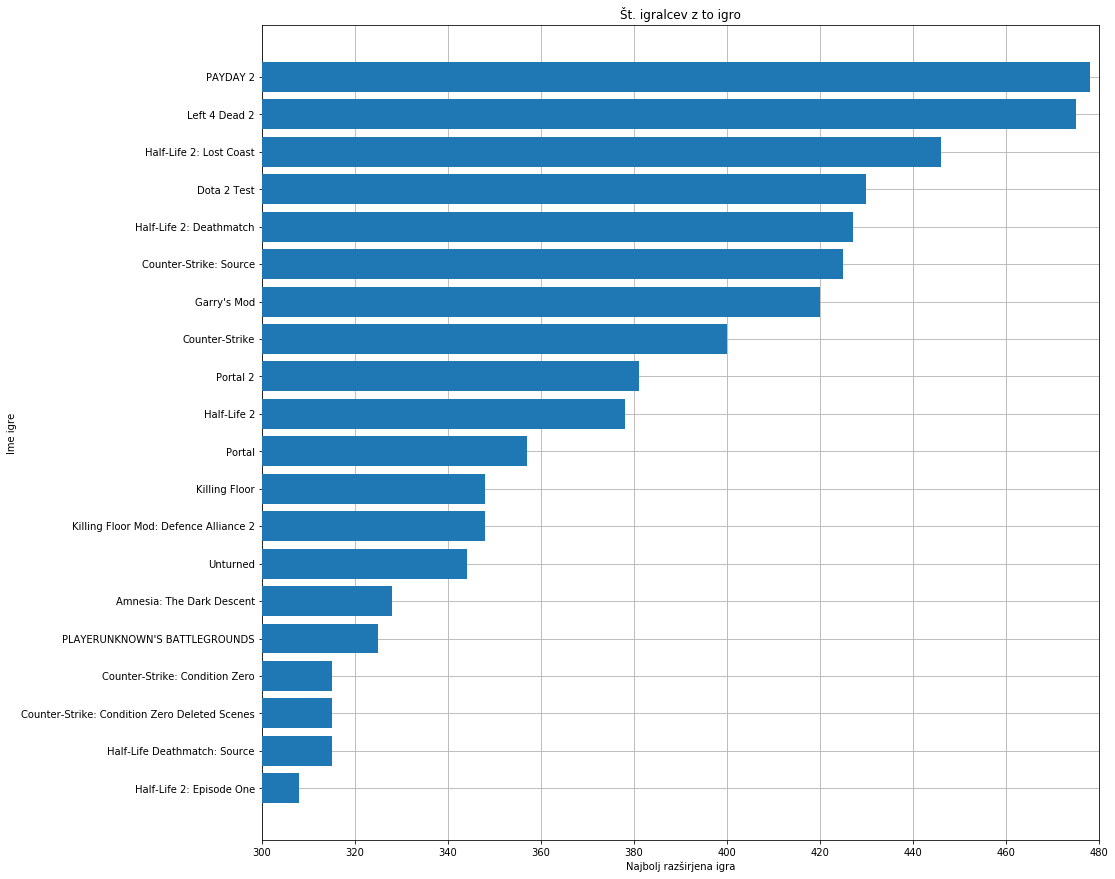

In [4]:
def getMostCommonGamesAndHighestPlaytimeSorted( player_games):
    globalGamePlayTime=dict()
    numberOfPlayersForGame=dict()
    for user in player_games:
        if(player_games[user]!={} and player_games[user]['game_count']!=0):
            for game_info in player_games[user]["games"]:
                if( game_info['appid'] not in globalGamePlayTime):
                    globalGamePlayTime[game_info['appid']]=game_info['playtime_forever']
                    numberOfPlayersForGame[game_info['appid']]=1
                else:
                    globalGamePlayTime[game_info['appid']]+=game_info['playtime_forever']
                    numberOfPlayersForGame[game_info['appid']]+=1
    TopTotalPlaytime= sorted(globalGamePlayTime.items(), key=lambda x: x[1], reverse=True)
    TopBoughtGames= sorted(numberOfPlayersForGame.items(), key=lambda x: x[1], reverse=True)
    return (TopBoughtGames,TopTotalPlaytime)


def plotTopPlaytimeGames( sortedGames):
    games=[]
    playtimes=[]
    for game,playtime in sortedGames:
        games.append(str(game_names[str(game)]))
        playtimes.append(playtime/60)
    y_pos = np.arange(len(games))
    plt.figure(figsize=(15,15))
    plt.grid(zorder=0)
    plt.barh(games,playtimes, align='center', zorder=4)
    #plt.yticks(y_pos, games)
    plt.xlabel("Čas igranja v urah")
    plt.title('Najbolj igrana igra')
    plt.ylabel("Ime igre")
    plt.savefig("assets/mostPlayed.png",dpi=200,bbox_inches="tight")
    plt.show()
    return None

def plotTopBoughtGames( sortedGames):
    games=[]
    playtimes=[]
    for game,playtime in sortedGames:
        games.append(str(game_names[str(game)]))
        playtimes.append(playtime)
    y_pos = np.arange(len(games))
    plt.figure(figsize=(15,15))
    plt.xlim(300,480)
    plt.grid(zorder=0)
    plt.barh(games,playtimes, align='center', zorder=4)
    #plt.yticks(y_pos, games)
    plt.xlabel("Najbolj razširjena igra")
    plt.title('Št. igralcev z to igro')
    plt.ylabel("Ime igre")
    plt.savefig("assets/boughtGames.png",dpi=200,bbox_inches="tight")
    plt.show()
    return None
(TopBoughtGames,TopTotalPlaytime)=getMostCommonGamesAndHighestPlaytimeSorted(player_games)
plotTopPlaytimeGames(TopTotalPlaytime[20:0:-1])
plotTopBoughtGames(TopBoughtGames[20:0:-1])

## Podatki iger
Tukaj poskušam najti najtežje in najlažje igre. Za vsak dosežek vsake igre vemo koliko procentov ljudi so ga naredili. Torej najtežja igra, smo predpostavili da je tista, ki ima povprečno najmanjše procente dokončanje dosežkov po igralcih.

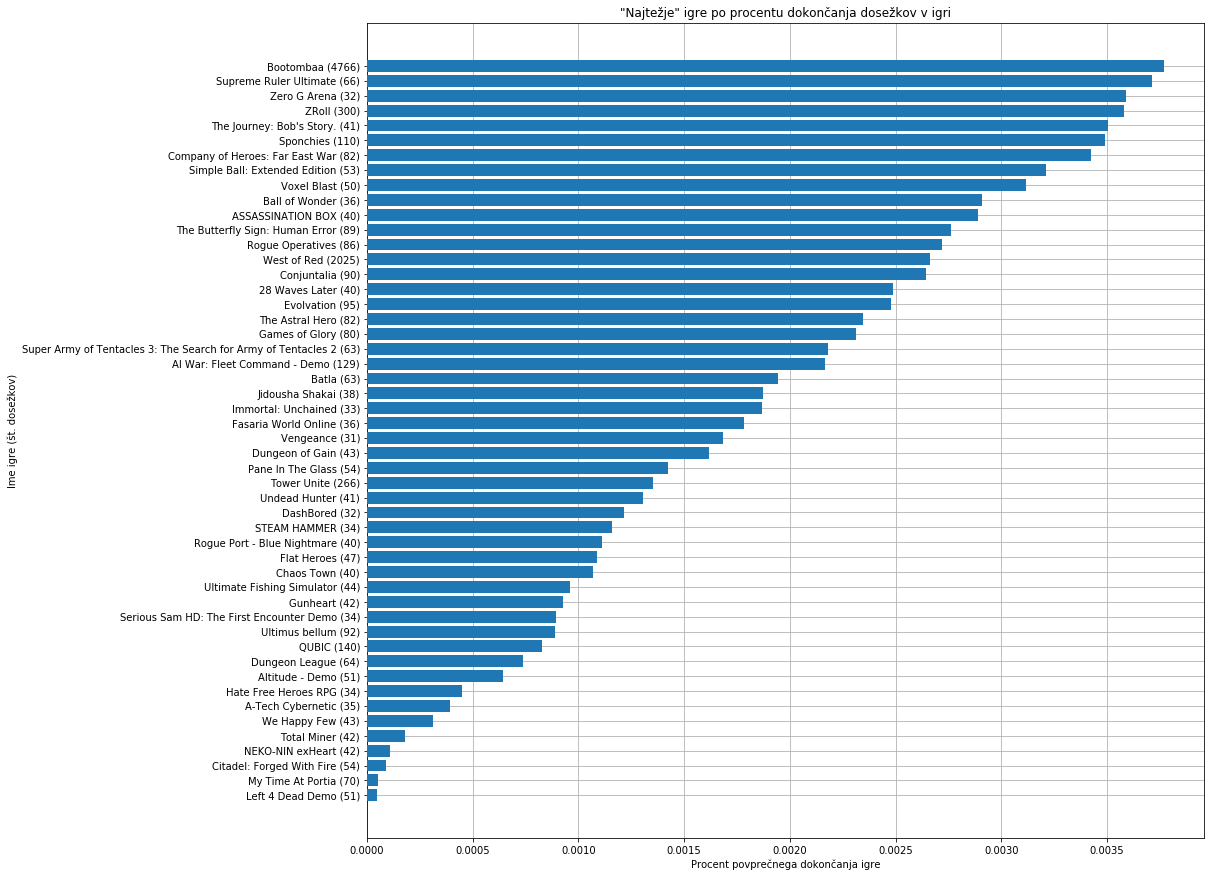

In [5]:
gameAverageFinish=[]
numOfAchievemts=dict()
for gid in global_game_stats:
    if(len(global_game_stats[str(gid)])!=0):
        povp=0
        num=0
        numOfAchievemts[gid]=0
        for stat in global_game_stats[str(gid)]['achievements']:
            numOfAchievemts[gid]+=1
            if(stat['percent']<=100):
                povp+=(stat['percent']/100)
                num+=1
        if(num>30 ):
            gameAverageFinish.append((gid,povp/num))
        
sortedGameAverageFinish= sorted(gameAverageFinish, key=lambda x: x[1], reverse=False)
sortedNumOfAchievements= sorted(numOfAchievemts.items(), key=lambda x: x[1], reverse=True) 
gameIds=[]
gameAvg=[]
for i in sortedGameAverageFinish[0:50]:
    gameIds.append(str(game_names[i[0]])+" ("+str(numOfAchievemts[i[0]])+")")
    gameAvg.append(i[1])
    
y_pos = np.arange(len(gameIds))
plt.figure(figsize=(15,15))
plt.grid(zorder=0)
plt.barh(gameIds,gameAvg, align='center', alpha=1, zorder=3)
#plt.yticks(y_pos, games)
plt.xlabel("Procent povprečnega dokončanja igre")
plt.ylabel("Ime igre (št. dosežkov)")
plt.title('"Najtežje" igre po procentu dokončanja dosežkov v igri')
plt.savefig("assets/hardestGames.png",dpi=200,bbox_inches="tight")
plt.show()


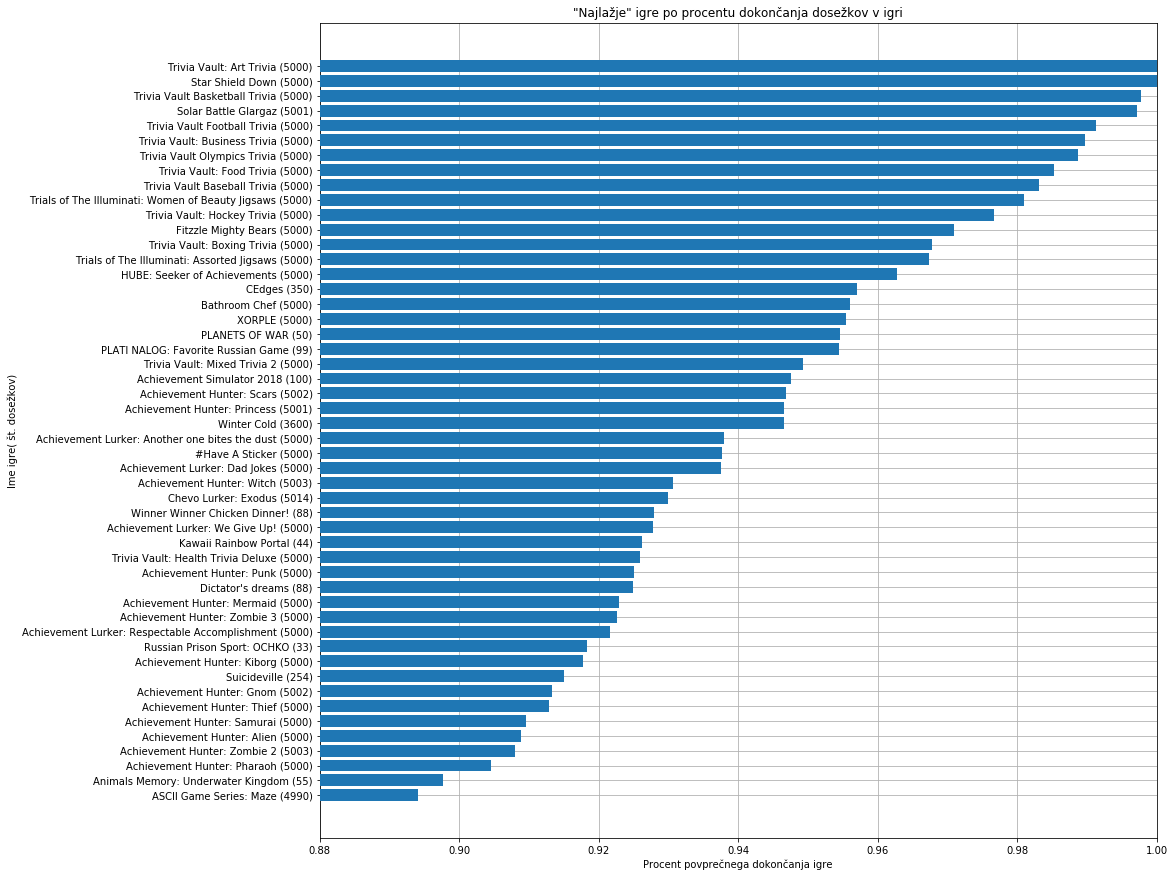

In [6]:
gameIds=[]
gameAvg=[]
for i in sortedGameAverageFinish[len(sortedGameAverageFinish)-51:len(sortedGameAverageFinish)-1]:
    gameIds.append(game_names[i[0]]+" ("+str(numOfAchievemts[i[0]])+")")
    gameAvg.append(i[1])

y_pos = np.arange(len(gameIds))
plt.figure(figsize=(15,15))
plt.grid(zorder=0)
plt.xlim(0.88,1)
plt.barh(gameIds,gameAvg, align='center', zorder=4)
#plt.yticks(y_pos, games)
plt.xlabel("Procent povprečnega dokončanja igre")
plt.ylabel("Ime igre( št. dosežkov)")
plt.title('"Najlažje" igre po procentu dokončanja dosežkov v igri')
plt.savefig("assets/easyAchievents.png",dpi=200,bbox_inches="tight")
plt.show()


Tukaj vidimo, da so med najlažjimi igrami same take, ki imajo zelo veliko dosežkov. Poglejmo še koliko je največ teh dosežkov v igri.

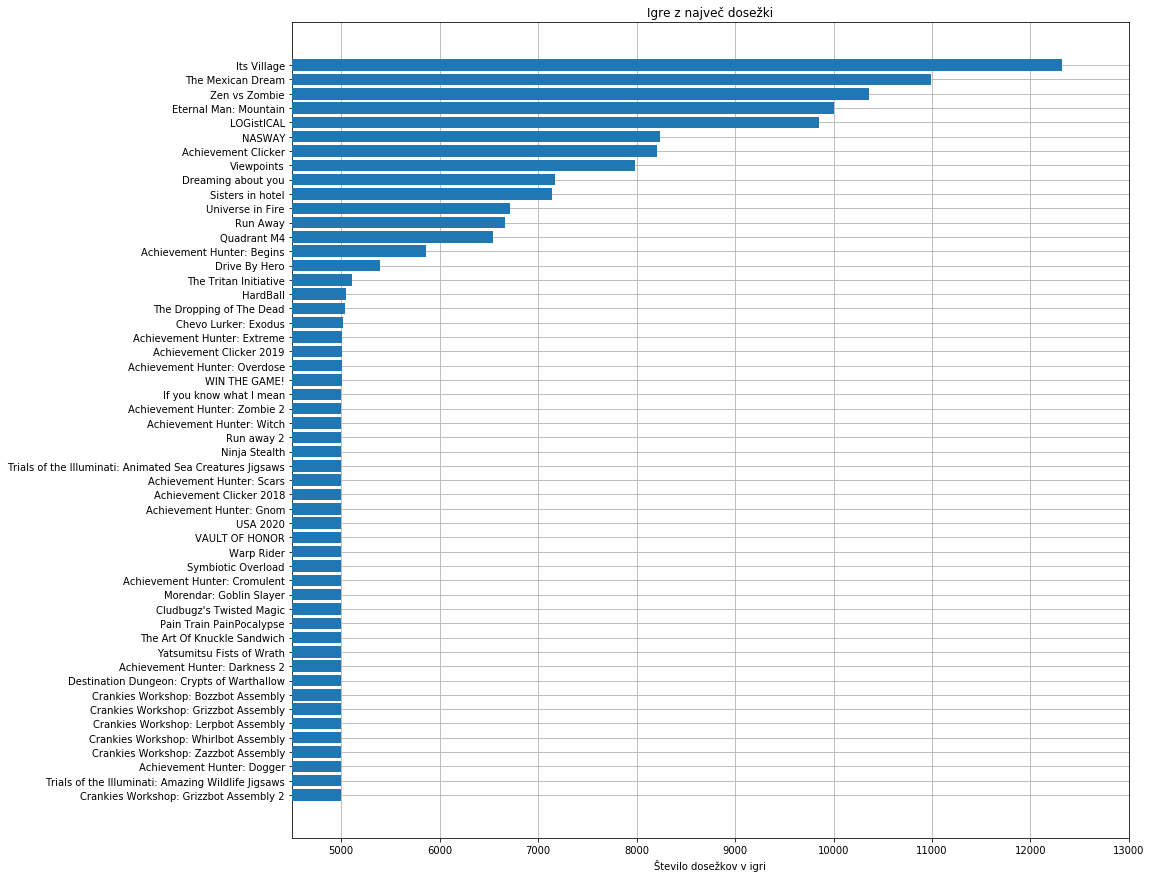

In [7]:
numGamesId=[]
numGamesNum=[]
for i in sortedNumOfAchievements[51:0:-1]:
    numGamesId.append(game_names[i[0]])
    numGamesNum.append(i[1])
i=sortedNumOfAchievements[0]
numGamesId.append(game_names[i[0]])
numGamesNum.append(i[1])
plt.figure(figsize=(15,15))
plt.xlim(4500,13000)
plt.grid(zorder=0)
plt.barh(numGamesId,numGamesNum, align='center', zorder=4)
#plt.yticks(y_pos, games)
plt.xlabel("Število dosežkov v igri")
plt.title('Igre z največ dosežki')
plt.savefig("assets/numOfAchievemts",dpi=200,bbox_inches="tight")
plt.show()

Če pogledamo te igre bližje, vidimo, da se jih večina konča v manj kot uri. Poglejmo kakšne imajo dejansko dosežke:


Dosežki igre z največ dosežki:  
![Alt text](assets/ach2.png?raw=true )  


Dosežki igre z drugim največjim dosežkim:  
![Alt text](assets/ach1.png?raw=true )  


Vidimo, da  sta to igre, kjer lahko "farmamo" dosežke, ker nekateri uporabniki to radi počnejo. Ampak niso vse igre take, četrta najboljša igra ima dejansko veliko dosežkov, njen čas dokončanja pa je kar 400 urni.  
![Alt text](assets/ach3.png?raw=true )  

## Podobnost med vzdevkom in imenom uporabnika
Tukaj bomo po Jaro indeksu razdalje pogledali razliko med vzdevkom in imenom uporabnika. Tukaj vidimo porazdelitev

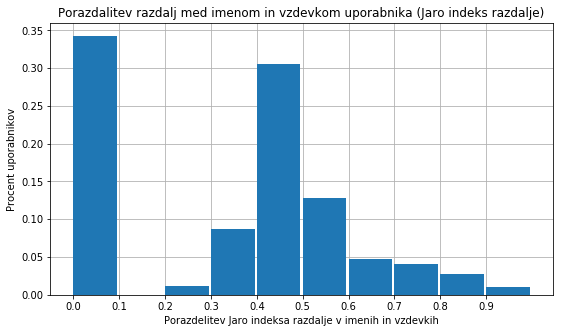

In [8]:

playerNamesSimilarity=[]
sameNames=[]
nameTabs=[0 for x in range(10)]
for pid in player_summaries:
    if('name' in player_summaries[pid] and 'rn' in player_summaries[pid]):
        a=jellyfish.jaro_distance(player_summaries[pid]['name'],player_summaries[pid]['rn'])
        playerNamesSimilarity.append(a)
        if(a<0.99 and a>0.8):
            sameNames.append((player_summaries[pid]['name'],player_summaries[pid]['rn']))
        nameTabs[math.floor(a*10)%10]+=1
j=sum(nameTabs)
for i in range(len(nameTabs)):
    nameTabs[i]=nameTabs[i]/j

plt.figure(figsize=(9,5))
labels=['0.0','0.1','0.2','0.3','0.4','0.5','0.6','0.7','0.8','0.9']

plt.grid(zorder=0)
plt.bar(labels,nameTabs, width=0.95, align='edge', alpha=1, zorder=3)
plt.xlabel("Porazdelitev Jaro indeksa razdalje v imenih in vzdevkih")
plt.title('Porazdalitev razdalj med imenom in vzdevkom uporabnika (Jaro indeks razdalje)')
plt.ylabel("Procent uporabnikov")
plt.savefig("assets/nameDistribution.png", dpi=200,bbox_inches="tight")
plt.show()

Vidimo, da ima od vradnost indeksa od 0.7 do 1 samo 10% uporabnikobv. Ti imajo izpeljanke imen, kot so nasledni:

In [9]:
selectedNames=[9,13,26,34,45,136,163,169,172,1251,1252,2010,2059]
print("'Vzdevek', 'Ime'")
for i in selectedNames:
    print(sameNames[i])

'Vzdevek', 'Ime'
('Thorvald', 'Thorvald ter Meer')
('Berra', 'Bernardo')
('Robingg', 'Robin B')
('KentKennedy #Akk!', 'Kent Kennedy')
('Bostjan88', 'Bostjan')
('AnzeDragar', 'Anze Dragar')
('Nikkoff', 'Nikko')
('ninos10', 'nino')
('NinaFin', 'Nina Fininis')
('Justin500 DE', 'Justin')
('JacobofGames', 'Jacob')
('Robertbtw', 'Robert')
('xXxBen_DoverxXx', 'Ben Dover')


Skoraj 35% uporabnikov ima ime čisto drugačno kot vzdevek, torej jih na internetu nočejo povezovati. Za ostale uporabnike pa ne moramo točno vedeti ali so izpeljanke ali ne, ker nam to indeks ne omogoča.  

## Analiza prepovedi igranja (Ban)
Najprej nas zanima, je razlika med uporabniki z privatnim in odprtim profilom?
### VAC ban

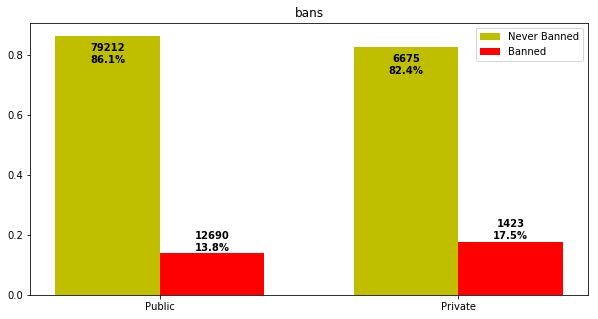

In [10]:
good, bad = get_vac_ban_visibility_data(player_summaries, player_bans)
ban_visibility_plot(good, bad, "vac_bans_vis.png")

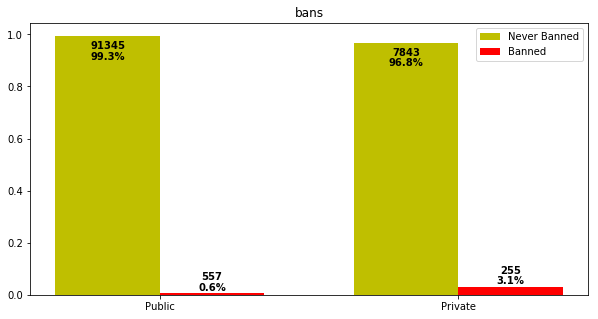

In [11]:
good, bad = get_community_ban_visibility_data(player_summaries, player_bans)
ban_visibility_plot(good, bad, "community_bans_vis.png")

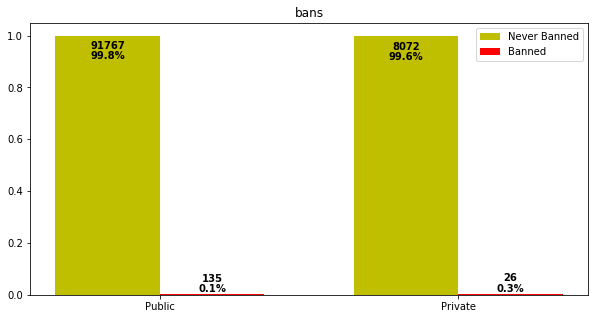

In [12]:
good, bad = get_economy_ban_visibility_data(player_summaries, player_bans)
ban_visibility_plot(good, bad, "economy_bans_vis.png")

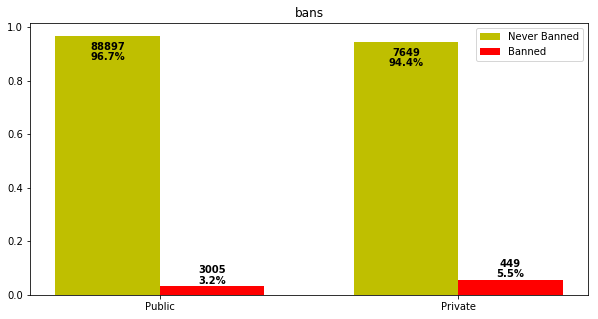

In [13]:
good, bad = get_game_ban_visibility_data(player_summaries, player_bans)
ban_visibility_plot(good, bad, "bame_bans_vis.png")


Vidimo, da je malenkostna razlike med procenti banov privatnih in javnih profilov, še posebaj pri VAC banih. Torej mit, da če imaš privatni profil, si heker imalo nekaj resnice.  
Kakšna pa je razlika med banim v različnih državah? 

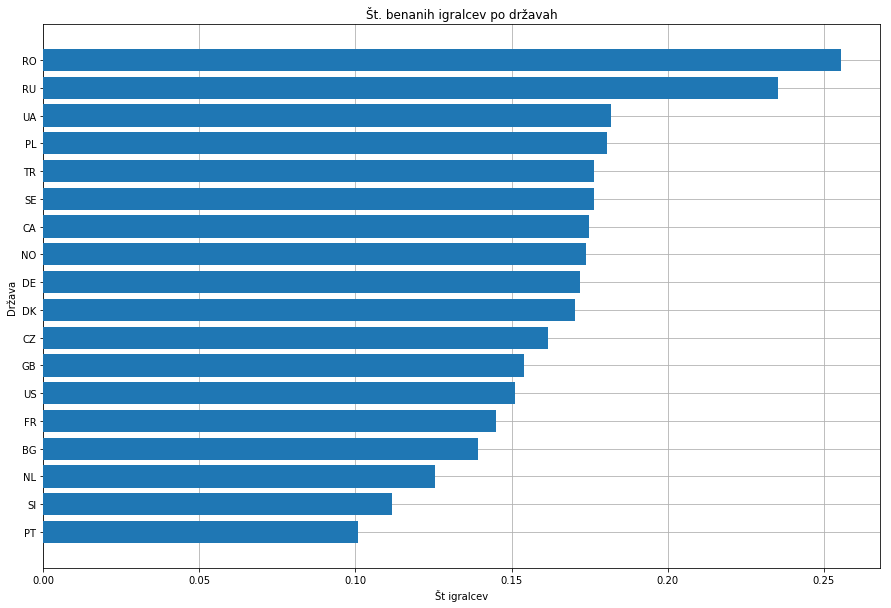

In [14]:
bans_by_country = dict()
for pid in player_ids:
    try:
        country = player_summaries[pid]["cntry"]
        if country not in bans_by_country:
            bans_by_country[country] = {"ban" : 0, "clean" : 0}
            if player_was_banned(player_bans[pid]):
                bans_by_country[country]["ban"] = bans_by_country[country]["ban"]+1
            else:
                bans_by_country[country]["clean"] = bans_by_country[country]["clean"]+1
        else:
            if player_was_banned(player_bans[pid]):
                bans_by_country[country]["ban"] = bans_by_country[country]["ban"]+1
            else:
                bans_by_country[country]["clean"] = bans_by_country[country]["clean"]+1
    except:
        pass
country_ban_percentages = dict()
for cntry, data in bans_by_country.items():
    if data["ban"]+data["clean"] > 1000:
        country_ban_percentages[cntry] = data["ban"]/(data["ban"]+data["clean"])
def plot_bans_by_country(bans):
    import numpy as np
    percentage=[]
    countries=[]
    for country,persons in bans:
        countries.append(country)
        percentage.append(persons)
    y_pos = np.arange(len(countries))
    plt.figure(figsize=(15,10))
    plt.grid(zorder=0)
    plt.barh(countries,percentage, align='center', zorder=5)
    #plt.yticks(y_pos, games)
    plt.xlabel("Št igralcev")
    plt.title('Št. benanih igralcev po državah')
    plt.ylabel("Država")
    plt.savefig("assets/bans_country.png",dpi=200,bbox_inches="tight")
    plt.show()
    return None
plot_bans_by_country(sorted(country_ban_percentages.items(), key=lambda x: x[1]))

Tukaj je precejšna razlika med Romunim in Rusim. Med Romuni in Slovenci je kar 15% razlika v številu banov uporabnikov.